# Handwritten Chinese Digit Recognizer

## [Dataset](https://www.kaggle.com/gpreda/chinese-mnist) 15000 64x64 .jpg


In [1]:
!pip install opendatasets --upgrade
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/gpreda/chinese-mnist'
od.download(dataset_url)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rushiky
Your Kaggle Key: ··········


100%|██████████| 16.5M/16.5M [00:00<00:00, 110MB/s] 

In [7]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import random
import skimage

## Prepare Dataset

In [3]:

df= pd.read_csv("chinese-mnist/chinese_mnist.csv", low_memory = False)
df.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [8]:
print("dataframe rows:", df.shape[0]) 
print("image files :", len(os.listdir("chinese-mnist/data/data/")))

dataframe rows: 15000
image files : 15000


In [9]:
def file_path_col(df):    
    file_path = f"input_{df[0]}_{df[1]}_{df[2]}.jpg" #input_1_1_10.jpg    
    return file_path

df["file_path"] = df.apply(file_path_col, axis = 1)
df.head()

,suite_id,sample_id,code,value,character,file_path
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


### split dataset

In [10]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True, stratify = df.code.values)
val_df, test_df   = train_test_split(df, test_size = 0.5, random_state = 42, shuffle = True, stratify = df.code.values)

print(train_df.shape[0])
print(val_df.shape[0])
print(test_df.shape[0])

12000
7500
7500


In [11]:
import skimage.io
import skimage.transform

file_paths = list(df.file_path)
def read_image(file_paths):
    image = skimage.io.imread("chinese-mnist/data/data/" + file_paths)
    image = skimage.transform.resize(image, (64, 64, 1), mode="reflect")   
    return image[:, :, :]

def character_encoder(df, var = "character"):
    x = np.stack(df["file_path"].apply(read_image))
    y = pd.get_dummies(df[var], drop_first = False)
    return x, y

In [12]:
x_train, y_train = character_encoder(train_df)
x_val, y_val = character_encoder(val_df)
x_test, y_test = character_encoder(test_df)

print(x_train.shape, ",", y_train.shape)
print(x_val.shape, ",", y_val.shape)
print(x_test.shape, ",", y_test.shape)

(12000, 64, 64, 1) , (12000, 15)
(7500, 64, 64, 1) , (7500, 15)
(7500, 64, 64, 1) , (7500, 15)


## Build Model

In [13]:
input_shape = (64,64,1)
num_classes = y_train.shape[1] 

In [14]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(layers.MaxPool2D(pool_size = (2, 2)))       
model.add(layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))      
model.add(layers.Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))    
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(num_classes, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

In [15]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

## Train Model

In [16]:
history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
94/94 [==============================] - 17s 47ms/step - loss: 1.1607 - accuracy: 0.6339 - val_loss: 0.3650 - val_accuracy: 0.8861
Epoch 2/20
94/94 [==============================] - 2s 19ms/step - loss: 0.2755 - accuracy: 0.9099 - val_loss: 0.1979 - val_accuracy: 0.9356
Epoch 3/20
94/94 [==============================] - 2s 18ms/step - loss: 0.1523 - accuracy: 0.9511 - val_loss: 0.1125 - val_accuracy: 0.9685
Epoch 4/20
94/94 [==============================] - 2s 18ms/step - loss: 0.0840 - accuracy: 0.9766 - val_loss: 0.0610 - val_accuracy: 0.9829
Epoch 5/20
94/94 [==============================] - 2s 18ms/step - loss: 0.0659 - accuracy: 0.9804 - val_loss: 0.0624 - val_accuracy: 0.9817
Epoch 6/20
94/94 [==============================] - 2s 18ms/step - loss: 0.0564 - accuracy: 0.9832 - val_loss: 0.0322 - val_accuracy: 0.9921
Epoch 7/20
94/94 [==============================] - 2s 18ms/step - loss: 0.0317 - accuracy: 0.9915 - val_loss: 0.0267 - val_accuracy: 0.9932
Epoch 8/20
9

### save model

In [17]:
model.save('chinese-mnist.h5')

## Evaluate Model

In [18]:
# Evaluate Model
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.02341156080365181
Test accuracy:  0.9950666427612305


### show training history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


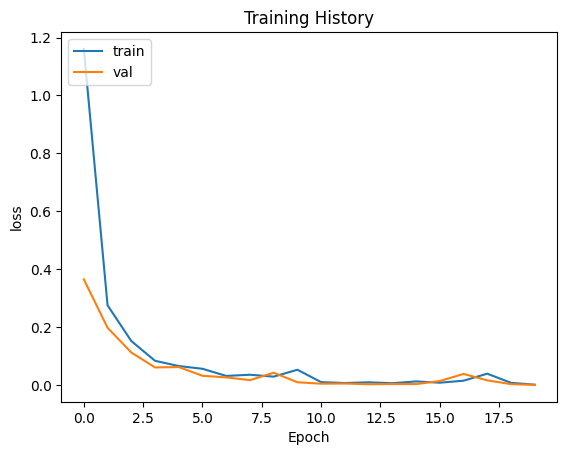

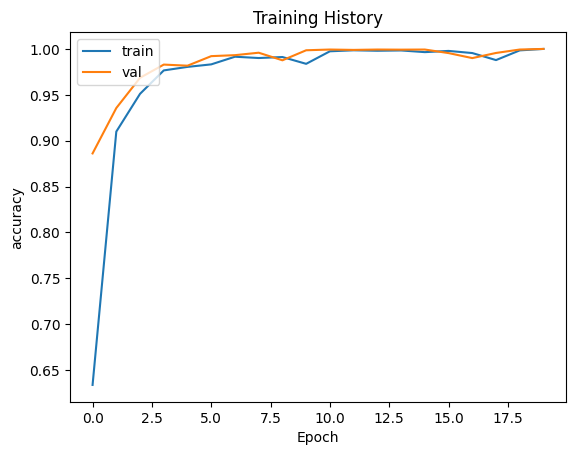

In [19]:
keys=history.history.keys()
print(keys)

def show_train_history(hisData,train,test): 
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[test])
    plt.title('Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

show_train_history(history, 'loss', 'val_loss')
show_train_history(history, 'accuracy', 'val_accuracy')